In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import astropy
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
from gatspy import datasets, periodic
import astropy.timeseries as astropy_timeseries

In [2]:
class correctedNaiveMultiband:
    def __init__(self,*args,**kwargs):
        
        self.args = args
        self.kwargs = kwargs
    def fit(self, T, M, ME, F):
        self.filters = pd.unique(F)
        self.models = {}
        for _filter in self.filters:
            cut = F==_filter
            self.models[_filter]=periodic.LombScargleFast(*self.args,**self.kwargs)
            self.models[_filter].optimizer.period_range=(0.1, 10)
            self.models[_filter].fit(T[cut],M[cut],ME[cut])
    def predict(self, T,filts):
        predictions = []
        for i,_filter in enumerate(pd.unique(filts[:,0])):
           
            predictions.append(self.models[_filter].predict(T[:,i]))
        return np.array(predictions)
    @property
    def best_period(self):
        return np.array([self.models[_filter].best_period for _filter in self.filters])
    def periodogram_auto(self):
        PA = [self.models[_filter].periodogram_auto() for _filter in self.filters]
        return np.array([p[0] for p in PA]), np.array([p[1] for p in PA])
    def periodogram(self,*args,**kwargs):
        return np.array([self.models[_filter].periodogram(*args,**kwargs) for _filter in self.filters])
            


In [24]:
from astropy.table import Table, vstack
ztf = Table.read("nph_light_curves?POS=CIRCLE 286.49621 16.098028 0.00055")

kwargs = {'format': 'ascii', 'names': ['t', 'mag', 'magerr', 'filt']}
ogle = Table.read("OGLE-GD-CEP-1442-I.dat", **kwargs)


ztf = ztf[ztf['oid']!=1585209400010477]
    
ztf['t'] = ztf['hjd']-2450000 - ztf['exptime']*0.5/(24*60*60)
ztf['filt'] = list(map(str, ztf['filtercode'].data))

df = vstack([ogle, ztf])
df = df.to_pandas()
df = df[['t','mag','magerr','filt']]
df.to_csv('testing_MC.csv')
df.groupby('filt').count()

/home/ktisanic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'oid' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'expid' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'catflags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'filefracday' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ktisanic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'field' from in

,t,mag,magerr
filt,,,
I,69,69,69
b'zg',200,200,200
b'zr',225,225,225


In [27]:
P0 = 3.27       

def testing(Number_in_simulation,TYPE='fast',doMC=True,Periodogram_auto=False):
    
    o = np.linspace(1/100,24,10000)
    def process(df, filters=list('IV')):
        
        if TYPE == 'fast':
            model = periodic.LombScargleMultibandFast(fit_period=True, Nterms=1)
            model.optimizer.period_range=(0.1, 10)
        if TYPE == 'slow':
            model = periodic.LombScargleMultiband(fit_period=True)
            model.optimizer.period_range=(0.1, 10)
        if TYPE == 'naive':
            #model = periodic.NaiveMultiband(fit_period=True)
            model = correctedNaiveMultiband(fit_period=True)
            
        # model.optimizer.period_range=(1./(24*4), 100)
        
        model.fit(df['t'], df['mag'], df['magerr'], df['filt'])
        #model.find_best_periods()
        

        tfit = np.linspace(0, model.best_period, 1000)
        filtsfit = np.array(filters)[:, np.newaxis]
        magfit = model.predict(tfit, filts=filtsfit)
        #print(model.best_period.shape,df['t'].shape,tfit.shape)
        if np.size(model.best_period)>1:
            phase = (df['t'][np.newaxis,:] / model.best_period[:,np.newaxis]) % 1
            phasefit = (tfit.T / model.best_period[:,np.newaxis])
        else:
            phase = (df['t'] / model.best_period) % 1
            phasefit = (tfit / model.best_period)
        #print(filtsfit.shape, magfit.shape)
        
        if Periodogram_auto:
            return np.mean(model.best_period), tfit, filtsfit, magfit, phasefit,model.periodogram_auto()
        return np.mean(model.best_period), tfit, filtsfit, magfit, phasefit,[o,model.periodogram(o)]
    df = pd.read_csv('testing_MC.csv')
    if doMC:
        DF = pd.DataFrame()
        for _filter in pd.unique(df['filt']):
            cut = df[df['filt']==_filter]
            DF = DF.append(cut.iloc[np.random.randint(0,cut.shape[0],min(Number_in_simulation,cut.shape[0])),:])
        df = DF.reset_index()
    
    K = process(df, np.unique(df["filt"]))
    #print(K[-1][0].shape,K[-1][1].shape, K[2].flatten().shape, K[3].shape,K[4].shape)
    #print(K[-1][0].shape, K[-1][1].shape)
    return  Number_in_simulation,K[0],\
            K[-1][0],\
            K[-1][1],\
            K[2].flatten(), K[3], K[4],TYPE
Kbf = testing(None, doMC=False,TYPE="naive",Periodogram_auto=True)    

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


#  Lomb Scargle Fast

In [46]:
MCN,MCPeriods,\
MCPeriodogram_p, MCPeriodogram_A,\
MCFilter, MCMag,  MCPhase,MCType\
    =np.vectorize(testing,signature="(),(),(),()->(),(),(a),(a),(b),(b,c),(c),()")(np.array([5*[i] for i in np.arange(5,200,5)]).flatten(),
                                                                                   "fast", True,False)
simulated_periodogram = pd.DataFrame({"N":np.tile(MCN,MCPeriodogram_p.shape[1]).reshape(-1,MCPeriods.size).T.flatten(),
                                     "P":np.tile(MCN,MCPeriodogram_p.shape[1]).reshape(-1,MCPeriods.size).T.flatten(),
                                     "o":MCPeriodogram_p.flatten(),
                                     'A':MCPeriodogram_A.flatten()
                                     })
simulated_periods= pd.DataFrame({"N":MCN,"P":MCPeriods})
lightcurve = pd.DataFrame()
for _filter in pd.unique(MCFilter.flatten()):
    
    cut = MCFilter==_filter
    phase =  MCPhase
    for i,N in enumerate(pd.unique(MCN)):
        
        lightcurve=lightcurve.append(pd.DataFrame({"N":MCPhase.shape[-1]*[N], 
                                                   "Filter":MCPhase.shape[-1]*[_filter], 
                                                   "phase":MCPhase[i], 
                                                   "mag":MCMag[cut][i],"kind":MCType[i]}),ignore_index=True)
lightcurve['phase bin'] = pd.cut(lightcurve.phase,20).apply(lambda x: x.mid)

lightcurve_p = lightcurve.groupby(["kind",'N','Filter','phase bin',]).agg({'mag': [
                                                                        lambda x: np.percentile(x,16),
                                                                        lambda x: np.percentile(x,50),
                                                                        lambda x: np.percentile(x,84)]})
lightcurve_p.columns = ['p_16', 'p_50', 'p_84']
lightcurve.to_csv('lightcurve.csv')
lightcurve_p.to_csv('lightcurve_p.csv')

Finding optimal frequency:
 - Estimated peak width = 0.0141
 - Using 5 steps per peak; omega_step = 0.00281
 - User-specified period range:  0.1 to 10
 - Computing periods at 22111 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0139
 - Using 5 steps per peak; omega_step = 0.00279
 - User-specified period range:  0.1 to 10
 - Computing periods at 22316 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0121
 - Using 5 steps per peak; omega_step = 0.00243
 - User-specified period range:  0.1 to 10
 - Computing periods at 25622 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28791 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0115
 - Using 5 steps per peak; omega_step = 0.0023
 - User-specified period range:  0.1 to 10
 - Computing periods at 27005 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27201 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29531 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0115
 - Using 5 steps per peak; omega_step = 0.00231
 - User-specified period range:  0.1 to 10
 - Computing periods at 26960 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28546 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29086 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00234
 - User-specified period range:  0.1 to 10
 - Computing periods at 26618 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00231
 - User-specified period range:  0.1 to 10
 - Computing periods at 26905 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00387
 - Using 5 steps per peak; omega_step = 0.000775
 - User-specified period range:  0.1 to 10
 - Computing periods at 80276 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00387
 - Using 5 steps per peak; omega_step = 0.000775
 - User-specified period range:  0.1 to 10
 - Computing periods at 80276 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30027 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28594 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00385
 - Using 5 steps per peak; omega_step = 0.00077
 - User-specified period range:  0.1 to 10
 - Computing periods at 80773 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29433 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00387
 - Using 5 steps per peak; omega_step = 0.000774
 - User-specified period range:  0.1 to 10
 - Computing periods at 80327 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00217
 - User-specified period range:  0.1 to 10
 - Computing periods at 28642 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00389
 - Using 5 steps per peak; omega_step = 0.000778
 - User-specified period range:  0.1 to 10
 - Computing periods at 79985 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27201 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00385
 - Using 5 steps per peak; omega_step = 0.00077
 - User-specified period range:  0.1 to 10
 - Computing periods at 80773 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81267 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00388
 - Using 5 steps per peak; omega_step = 0.000776
 - User-specified period range:  0.1 to 10
 - Computing periods at 80183 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000766
 - User-specified period range:  0.1 to 10
 - Computing periods at 81218 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81267 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00388
 - Using 5 steps per peak; omega_step = 0.000776
 - User-specified period range:  0.1 to 10
 - Computing periods at 80133 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81268 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000767
 - User-specified period range:  0.1 to 10
 - Computing periods at 81119 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81810 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81810 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00395
 - Using 5 steps per peak; omega_step = 0.000789
 - User-specified period range:  0.1 to 10
 - Computing periods at 78796 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00387
 - Using 5 steps per peak; omega_step = 0.000774
 - User-specified period range:  0.1 to 10
 - Computing periods at 80327 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81810 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00389
 - Using 5 steps per peak; omega_step = 0.000777
 - User-specified period range:  0.1 to 10
 - Computing periods at 80030 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00385
 - Using 5 steps per peak; omega_step = 0.00077
 - User-specified period range:  0.1 to 10
 - Computing periods at 80773 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000766
 - User-specified period range:  0.1 to 10
 - Computing periods at 81218 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000766
 - User-specified period range:  0.1 to 10
 - Computing periods at 81217 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81810 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29482 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00398
 - Using 5 steps per peak; omega_step = 0.000796
 - User-specified period range:  0.1 to 10
 - Computing periods at 78153 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00384
 - Using 5 steps per peak; omega_step = 0.000767
 - User-specified period range:  0.1 to 10
 - Computing periods at 81069 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00384
 - Using 5 steps per peak; omega_step = 0.000769
 - User-specified period range:  0.1 to 10
 - Computing periods at 80922 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00391
 - Using 5 steps per peak; omega_step = 0.000781
 - User-specified period range:  0.1 to 10
 - Computing periods at 79637 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81366 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000786
 - User-specified period range:  0.1 to 10
 - Computing periods at 79091 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79240 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29631 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00386
 - Using 5 steps per peak; omega_step = 0.000772
 - User-specified period range:  0.1 to 10
 - Computing periods at 80573 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00391
 - Using 5 steps per peak; omega_step = 0.000781
 - User-specified period range:  0.1 to 10
 - Computing periods at 79637 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000761
 - User-specified period range:  0.1 to 10
 - Computing periods at 81712 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00395
 - Using 5 steps per peak; omega_step = 0.000791
 - User-specified period range:  0.1 to 10
 - Computing periods at 78648 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00395
 - Using 5 steps per peak; omega_step = 0.000789
 - User-specified period range:  0.1 to 10
 - Computing periods at 78796 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00395
 - Using 5 steps per peak; omega_step = 0.000791
 - User-specified period range:  0.1 to 10
 - Computing periods at 78648 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00391
 - Using 5 steps per peak; omega_step = 0.000781
 - User-specified period range:  0.1 to 10
 - Computing periods at 79637 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000766
 - User-specified period range:  0.1 to 10
 - Computing periods at 81218 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81810 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00383
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000786
 - User-specified period range:  0.1 to 10
 - Computing periods at 79091 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81366 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00381
 - Using 5 steps per peak; omega_step = 0.000762
 - User-specified period range:  0.1 to 10
 - Computing periods at 81662 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0038
 - Using 5 steps per peak; omega_step = 0.00076
 - User-specified period range:  0.1 to 10
 - Computing periods at 81861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000765
 - User-specified period range:  0.1 to 10
 - Computing periods at 81366 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00382
 - Using 5 steps per peak; omega_step = 0.000764
 - User-specified period range:  0.1 to 10
 - Computing periods at 81417 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000757
 - User-specified period range:  0.1 to 10
 - Computing periods at 82207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00378
 - Using 5 steps per peak; omega_step = 0.000756
 - User-specified period range:  0.1 to 10
 - Computing periods at 82257 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


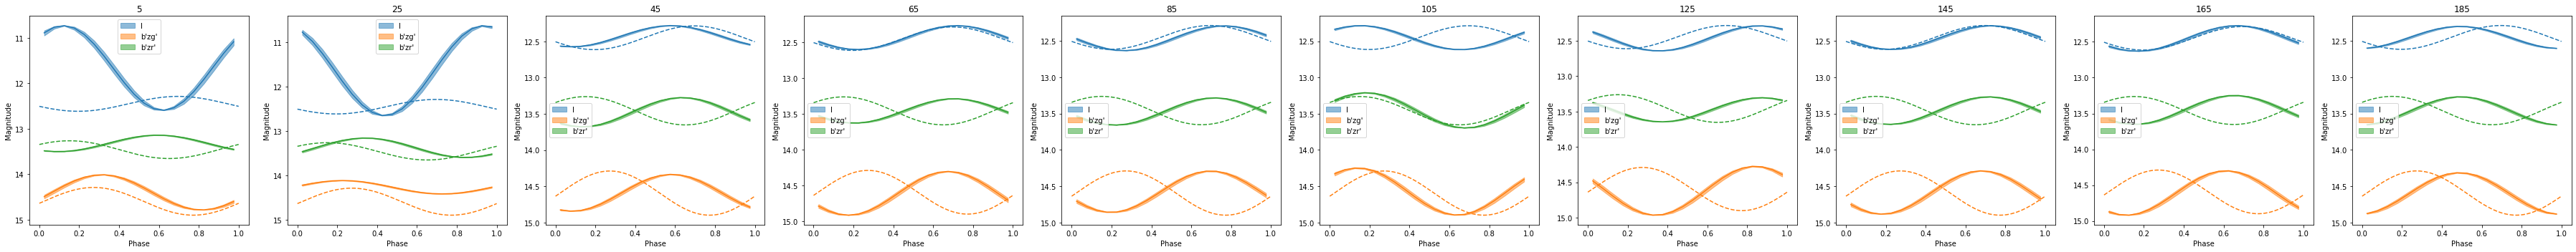

In [47]:
bins = pd.unique(lightcurve_p.index.get_level_values(1))[::4]
fig,ax = plt.subplots(1,bins.size,figsize=(5*bins.size,5))
ax = np.reshape(ax,-1)
for TYPE in pd.unique(pd.unique(lightcurve_p.index.get_level_values(0))):
    for i,N in enumerate(bins):
        for f in pd.unique(lightcurve_p.index.get_level_values(2)):
            m = lightcurve_p.loc[(TYPE,N,f)]
            _=ax[i].plot(m.index,m['p_50'])[0].get_color()
            cut = Kbf[4]==f
            
            ax[i].plot(Kbf[6][cut][0],Kbf[5][cut][0],color=_,ls='dashed')
            ax[i].fill_between(m.index,m['p_16'],m['p_84'],alpha=0.5,color=_,label=f)
        ax[i].legend()
        ax[i].set_xlabel('Phase')
        ax[i].set_ylabel('Magnitude')
        ax[i].set_title(N)
        ax[i].invert_yaxis()
fig.tight_layout()

Text(0, 0.5, 'Period [d]')

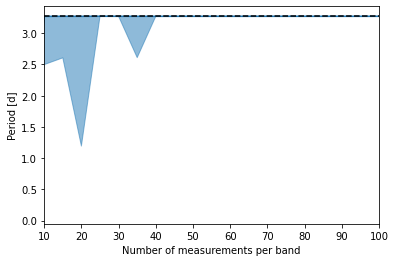

In [48]:
mean = simulated_periods.groupby(simulated_periods['N'],).median()
p16 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),16))
p84 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),84))
plt.plot(mean.index,mean.P)
plt.fill_between(mean.index,p16.P,p84.P,alpha=0.5,color='C0')
plt.xlim(10,100)
plt.axhline(P0,color='k',ls='dashed')
plt.xlabel('Number of measurements per band')
plt.ylabel('Period [d]')

# Naive Multiband

In [41]:
MCN,MCPeriods,\
MCPeriodogram_p, MCPeriodogram_A,\
MCFilter, MCMag,  MCPhase,MCType\
    =np.vectorize(testing,signature="(),(),(),()->(),(),(a),(b,a),(b),(b,c),(b,c),()")(np.array([5*[i] for i in np.arange(5,200,5)]).flatten(),
                                                                                   "naive", True,False)


simulated_periods= pd.DataFrame({"N":MCN,"P":MCPeriods})
lightcurve = pd.DataFrame()
for _filter in pd.unique(MCFilter.flatten()):
    
    cut = MCFilter==_filter
    phase =  MCPhase
    for i,N in enumerate(pd.unique(MCN)):
        
        lightcurve=lightcurve.append(pd.DataFrame({"N":MCPhase.shape[-1]*[N], 
                                                   "Filter":MCPhase.shape[-1]*[_filter], 
                                                   "phase":MCPhase[cut][i], 
                                                   "mag":MCMag[cut][i],"kind":MCType[i]}),ignore_index=True)
lightcurve['phase bin'] = pd.cut(lightcurve.phase,20).apply(lambda x: x.mid)

lightcurve_p = lightcurve.groupby(["kind",'N','Filter','phase bin',]).agg({'mag': [
                                                                        lambda x: np.percentile(x,16),
                                                                        lambda x: np.percentile(x,50),
                                                                        lambda x: np.percentile(x,84)]})
lightcurve_p.columns = ['p_16', 'p_50', 'p_84']

lightcurve.to_csv('lightcurve_naive.csv')
lightcurve_p.to_csv('lightcurve_p_naive.csv')

Finding optimal frequency:
 - Estimated peak width = 0.0175
 - Using 5 steps per peak; omega_step = 0.00349
 - User-specified period range:  0.1 to 10
 - Computing periods at 17818 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0158
 - Using 5 steps per peak; omega_step = 0.00317
 - User-specified period range:  0.1 to 10
 - Computing periods at 19654 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0201
 - Using 5 steps per peak; omega_step = 0.00401
 - User-specified period range:  0.1 to 10
 - Computing periods at 15500 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0716
 - Using 5 steps per peak; omega_step = 0.0143
 - User-specified period range:  0.1 to 10
 - Computing periods at 4347 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0156
 - Using 5 steps per peak; omega_step = 0.00311
 - User-specified period range:  0.1 to 10
 - Computing periods at 19993 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0157
 - Using 5 steps per peak; omega_step = 0.00314
 - User-specified period range:  0.1 to 10
 - Computing periods at 19842 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.07
 - Using 5 steps per peak; omega_step = 0.014
 - User-specified period range:  0.1 to 10
 - Computing periods at 4442 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0161
 - Using 5 steps per peak; omega_step = 0.00322
 - User-specified period range:  0.1 to 10
 - Computing periods at 19309 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0155
 - Using 5 steps per peak; omega_step = 0.0031
 - User-specified period range:  0.1 to 10
 - Computing periods at 20044 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0174
 - Using 5 steps per peak; omega_step = 0.00347
 - User-specified period range:  0.1 to 10
 - Computing periods at 17918 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29037 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0211
 - Using 5 steps per peak; omega_step = 0.00422
 - User-specified period range:  0.1 to 10
 - Computing periods at 14756 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.015
 - Using 5 steps per peak; omega_step = 0.00301
 - User-specified period range:  0.1 to 10
 - Computing periods at 20688 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0144
 - Using 5 steps per peak; omega_step = 0.00289
 - User-specified period range:  0.1 to 10
 - Computing periods at 21525 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0186
 - Using 5 steps per peak; omega_step = 0.00372
 - User-specified period range:  0.1 to 10
 - Computing periods at 16735 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0154
 - Using 5 steps per peak; omega_step = 0.00309
 - User-specified period range:  0.1 to 10
 - Computing periods at 20141 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00236
 - User-specified period range:  0.1 to 10
 - Computing periods at 26367 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0153
 - Using 5 steps per peak; omega_step = 0.00307
 - User-specified period range:  0.1 to 10
 - Computing periods at 20294 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0161
 - Using 5 steps per peak; omega_step = 0.00322
 - User-specified period range:  0.1 to 10
 - Computing periods at 19298 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27408 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0158
 - Using 5 steps per peak; omega_step = 0.00317
 - User-specified period range:  0.1 to 10
 - Computing periods at 19647 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0157
 - Using 5 steps per peak; omega_step = 0.00314
 - User-specified period range:  0.1 to 10
 - Computing periods at 19793 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0121
 - Using 5 steps per peak; omega_step = 0.00243
 - User-specified period range:  0.1 to 10
 - Computing periods at 25626 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0131
 - Using 5 steps per peak; omega_step = 0.00262
 - User-specified period range:  0.1 to 10
 - Computing periods at 23750 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00274
 - User-specified period range:  0.1 to 10
 - Computing periods at 22717 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0125
 - Using 5 steps per peak; omega_step = 0.0025
 - User-specified period range:  0.1 to 10
 - Computing periods at 24835 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0138
 - Using 5 steps per peak; omega_step = 0.00276
 - User-specified period range:  0.1 to 10
 - Computing periods at 22512 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0162
 - Using 5 steps per peak; omega_step = 0.00324
 - User-specified period range:  0.1 to 10
 - Computing periods at 19203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29581 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.012
 - Using 5 steps per peak; omega_step = 0.0024
 - User-specified period range:  0.1 to 10
 - Computing periods at 25920 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0151
 - Using 5 steps per peak; omega_step = 0.00301
 - User-specified period range:  0.1 to 10
 - Computing periods at 20635 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27211 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0135
 - Using 5 steps per peak; omega_step = 0.00271
 - User-specified period range:  0.1 to 10
 - Computing periods at 22959 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0159
 - Using 5 steps per peak; omega_step = 0.00318
 - User-specified period range:  0.1 to 10
 - Computing periods at 19546 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28098 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27952 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0127
 - Using 5 steps per peak; omega_step = 0.00255
 - User-specified period range:  0.1 to 10
 - Computing periods at 24441 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0131
 - Using 5 steps per peak; omega_step = 0.00262
 - User-specified period range:  0.1 to 10
 - Computing periods at 23701 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00396
 - Using 5 steps per peak; omega_step = 0.000792
 - User-specified period range:  0.1 to 10
 - Computing periods at 78540 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00236
 - User-specified period range:  0.1 to 10
 - Computing periods at 26367 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28594 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00409
 - Using 5 steps per peak; omega_step = 0.000817
 - User-specified period range:  0.1 to 10
 - Computing periods at 76118 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.013
 - Using 5 steps per peak; omega_step = 0.0026
 - User-specified period range:  0.1 to 10
 - Computing periods at 23949 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0126
 - Using 5 steps per peak; omega_step = 0.00251
 - User-specified period range:  0.1 to 10
 - Computing periods at 24736 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00398
 - Using 5 steps per peak; omega_step = 0.000797
 - User-specified period range:  0.1 to 10
 - Computing periods at 78095 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27357 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27901 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0164
 - Using 5 steps per peak; omega_step = 0.00328
 - User-specified period range:  0.1 to 10
 - Computing periods at 18956 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26765 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27751 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0122
 - Using 5 steps per peak; omega_step = 0.00243
 - User-specified period range:  0.1 to 10
 - Computing periods at 25578 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0148
 - Using 5 steps per peak; omega_step = 0.00296
 - User-specified period range:  0.1 to 10
 - Computing periods at 21032 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29531 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0119
 - Using 5 steps per peak; omega_step = 0.00238
 - User-specified period range:  0.1 to 10
 - Computing periods at 26170 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0164
 - Using 5 steps per peak; omega_step = 0.00328
 - User-specified period range:  0.1 to 10
 - Computing periods at 18954 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29186 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26862 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0138
 - Using 5 steps per peak; omega_step = 0.00275
 - User-specified period range:  0.1 to 10
 - Computing periods at 22616 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27805 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0122
 - Using 5 steps per peak; omega_step = 0.00245
 - User-specified period range:  0.1 to 10
 - Computing periods at 25427 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28594 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0124
 - Using 5 steps per peak; omega_step = 0.00248
 - User-specified period range:  0.1 to 10
 - Computing periods at 25086 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0141
 - Using 5 steps per peak; omega_step = 0.00282
 - User-specified period range:  0.1 to 10
 - Computing periods at 22070 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00212
 - User-specified period range:  0.1 to 10
 - Computing periods at 29284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0128
 - Using 5 steps per peak; omega_step = 0.00256
 - User-specified period range:  0.1 to 10
 - Computing periods at 24293 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0188
 - Using 5 steps per peak; omega_step = 0.00376
 - User-specified period range:  0.1 to 10
 - Computing periods at 16535 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28939 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00231
 - User-specified period range:  0.1 to 10
 - Computing periods at 26916 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.000811
 - User-specified period range:  0.1 to 10
 - Computing periods at 76713 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28742 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27207 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00398
 - Using 5 steps per peak; omega_step = 0.000797
 - User-specified period range:  0.1 to 10
 - Computing periods at 78096 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26813 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0128
 - Using 5 steps per peak; omega_step = 0.00256
 - User-specified period range:  0.1 to 10
 - Computing periods at 24292 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00409
 - Using 5 steps per peak; omega_step = 0.000819
 - User-specified period range:  0.1 to 10
 - Computing periods at 75969 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28197 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27900 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0139
 - Using 5 steps per peak; omega_step = 0.00277
 - User-specified period range:  0.1 to 10
 - Computing periods at 22417 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.0022
 - User-specified period range:  0.1 to 10
 - Computing periods at 28295 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00228
 - User-specified period range:  0.1 to 10
 - Computing periods at 27256 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.012
 - Using 5 steps per peak; omega_step = 0.00239
 - User-specified period range:  0.1 to 10
 - Computing periods at 26021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29038 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0124
 - Using 5 steps per peak; omega_step = 0.00248
 - User-specified period range:  0.1 to 10
 - Computing periods at 25036 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29582 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00409
 - Using 5 steps per peak; omega_step = 0.000817
 - User-specified period range:  0.1 to 10
 - Computing periods at 76118 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00209
 - User-specified period range:  0.1 to 10
 - Computing periods at 29732 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0121
 - Using 5 steps per peak; omega_step = 0.00243
 - User-specified period range:  0.1 to 10
 - Computing periods at 25627 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79085 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29038 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28198 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00396
 - Using 5 steps per peak; omega_step = 0.000792
 - User-specified period range:  0.1 to 10
 - Computing periods at 78540 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28840 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0139
 - Using 5 steps per peak; omega_step = 0.00278
 - User-specified period range:  0.1 to 10
 - Computing periods at 22410 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27952 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28347 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00394
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79035 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0119
 - Using 5 steps per peak; omega_step = 0.00237
 - User-specified period range:  0.1 to 10
 - Computing periods at 26223 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0122
 - Using 5 steps per peak; omega_step = 0.00244
 - User-specified period range:  0.1 to 10
 - Computing periods at 25528 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22756 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29237 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0127
 - Using 5 steps per peak; omega_step = 0.00253
 - User-specified period range:  0.1 to 10
 - Computing periods at 24587 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29088 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00236
 - User-specified period range:  0.1 to 10
 - Computing periods at 26319 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.012
 - Using 5 steps per peak; omega_step = 0.0024
 - User-specified period range:  0.1 to 10
 - Computing periods at 25877 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26861 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0121
 - Using 5 steps per peak; omega_step = 0.00242
 - User-specified period range:  0.1 to 10
 - Computing periods at 25724 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28347 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.000811
 - User-specified period range:  0.1 to 10
 - Computing periods at 76713 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00225
 - User-specified period range:  0.1 to 10
 - Computing periods at 27701 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00406
 - Using 5 steps per peak; omega_step = 0.000811
 - User-specified period range:  0.1 to 10
 - Computing periods at 76664 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29630 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.012
 - Using 5 steps per peak; omega_step = 0.00239
 - User-specified period range:  0.1 to 10
 - Computing periods at 26025 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_

Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27508 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00237
 - User-specified period range:  0.1 to 10
 - Computing periods at 26268 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0138
 - Using 5 steps per peak; omega_step = 0.00275
 - User-specified period range:  0.1 to 10
 - Computing periods at 22616 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29186 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00234
 - User-specified period range:  0.1 to 10
 - Computing periods at 26622 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00407
 - Using 5 steps per peak; omega_step = 0.000814
 - User-specified period range:  0.1 to 10
 - Computing periods at 76465 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29087 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27553 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00212
 - User-specified period range:  0.1 to 10
 - Computing periods at 29284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0128
 - Using 5 steps per peak; omega_step = 0.00257
 - User-specified period range:  0.1 to 10
 - Computing periods at 24242 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27404 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00275
 - User-specified period range:  0.1 to 10
 - Computing periods at 22658 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27756 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27405 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79234 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29236 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00228
 - User-specified period range:  0.1 to 10
 - Computing periods at 27256 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28346 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 28002 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00217
 - User-specified period range:  0.1 to 10
 - Computing periods at 28643 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00406
 - Using 5 steps per peak; omega_step = 0.000811
 - User-specified period range:  0.1 to 10
 - Computing periods at 76664 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27755 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00221
 - User-specified period range:  0.1 to 10
 - Computing periods at 28198 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29631 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29186 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00237
 - User-specified period range:  0.1 to 10
 - Computing periods at 26269 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29087 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00225
 - User-specified period range:  0.1 to 10
 - Computing periods at 27701 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29086 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00233
 - User-specified period range:  0.1 to 10
 - Computing periods at 26667 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00217
 - User-specified period range:  0.1 to 10
 - Computing periods at 28692 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27357 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00229
 - User-specified period range:  0.1 to 10
 - Computing periods at 27208 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27357 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29187 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27800 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.0022
 - User-specified period range:  0.1 to 10
 - Computing periods at 28246 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27952 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28940 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27360 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27901 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28396 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00234
 - User-specified period range:  0.1 to 10
 - Computing periods at 26614 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29531 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00235
 - User-specified period range:  0.1 to 10
 - Computing periods at 26465 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26762 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0118
 - Using 5 steps per peak; omega_step = 0.00236
 - User-specified period range:  0.1 to 10
 - Computing periods at 26366 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29087 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79234 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00216
 - User-specified period range:  0.1 to 10
 - Computing periods at 28742 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0117
 - Using 5 steps per peak; omega_step = 0.00235
 - User-specified period range:  0.1 to 10
 - Computing periods at 26515 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29581 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29037 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29482 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29433 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30027 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00231
 - User-specified period range:  0.1 to 10
 - Computing periods at 26911 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00396
 - Using 5 steps per peak; omega_step = 0.000792
 - User-specified period range:  0.1 to 10
 - Computing periods at 78590 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00394
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79035 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28988 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0115
 - Using 5 steps per peak; omega_step = 0.0023
 - User-specified period range:  0.1 to 10
 - Computing periods at 27013 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.000811
 - User-specified period range:  0.1 to 10
 - Computing periods at 76713 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29187 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29237 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27553 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29630 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00212
 - User-specified period range:  0.1 to 10
 - Computing periods at 29384 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27751 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22756 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27901 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30027 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0108
 - Using 5 steps per peak; omega_step = 0.00217
 - User-specified period range:  0.1 to 10
 - Computing periods at 28691 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79234 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29581 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27503 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.000811
 - User-specified period range:  0.1 to 10
 - Computing periods at 76713 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27505 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29482 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27553 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28396 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79234 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27851 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27410 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0114
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27362 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00394
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79035 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29087 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27901 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27952 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29236 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27800 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27751 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0138
 - Using 5 steps per peak; omega_step = 0.00275
 - User-specified period range:  0.1 to 10
 - Computing periods at 22609 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00215
 - User-specified period range:  0.1 to 10
 - Computing periods at 28939 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.0137
 - Using 5 steps per peak; omega_step = 0.00273
 - User-specified period range:  0.1 to 10
 - Computing periods at 22763 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29237 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00227
 - User-specified period range:  0.1 to 10
 - Computing periods at 27405 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29631 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29236 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29978 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27900 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29630 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27503 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29531 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00393
 - Using 5 steps per peak; omega_step = 0.000787
 - User-specified period range:  0.1 to 10
 - Computing periods at 79085 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.00211
 - User-specified period range:  0.1 to 10
 - Computing periods at 29532 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27952 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0116
 - Using 5 steps per peak; omega_step = 0.00232
 - User-specified period range:  0.1 to 10
 - Computing periods at 26861 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29237 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29631 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0106
 - Using 5 steps per peak; omega_step = 0.00213
 - User-specified period range:  0.1 to 10
 - Computing periods at 29237 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30077 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0113
 - Using 5 steps per peak; omega_step = 0.00226
 - User-specified period range:  0.1 to 10
 - Computing periods at 27553 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29086 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0107
 - Using 5 steps per peak; omega_step = 0.00214
 - User-specified period range:  0.1 to 10
 - Computing periods at 29087 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28445 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79284 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27850 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00395
 - Using 5 steps per peak; omega_step = 0.000791
 - User-specified period range:  0.1 to 10
 - Computing periods at 78688 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27901 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29631 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00405
 - Using 5 steps per peak; omega_step = 0.00081
 - User-specified period range:  0.1 to 10
 - Computing periods at 76811 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27900 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.011
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28396 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29680 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000785
 - User-specified period range:  0.1 to 10
 - Computing periods at 79283 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00208
 - User-specified period range:  0.1 to 10
 - Computing periods at 29882 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00218
 - User-specified period range:  0.1 to 10
 - Computing periods at 28494 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0105
 - Using 5 steps per peak; omega_step = 0.0021
 - User-specified period range:  0.1 to 10
 - Computing periods at 29681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00223
 - User-specified period range:  0.1 to 10
 - Computing periods at 27950 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000783
 - User-specified period range:  0.1 to 10
 - Computing periods at 79431 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0103
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30078 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0112
 - Using 5 steps per peak; omega_step = 0.00224
 - User-specified period range:  0.1 to 10
 - Computing periods at 27802 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79381 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0111
 - Using 5 steps per peak; omega_step = 0.00222
 - User-specified period range:  0.1 to 10
 - Computing periods at 27999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


Finding optimal frequency:
 - Estimated peak width = 0.00392
 - Using 5 steps per peak; omega_step = 0.000784
 - User-specified period range:  0.1 to 10
 - Computing periods at 79333 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0104
 - Using 5 steps per peak; omega_step = 0.00207
 - User-specified period range:  0.1 to 10
 - Computing periods at 30028 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.0109
 - Using 5 steps per peak; omega_step = 0.00219
 - User-specified period range:  0.1 to 10
 - Computing periods at 28447 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/ktisanic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/ktisanic/anaconda3/lib/python3.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


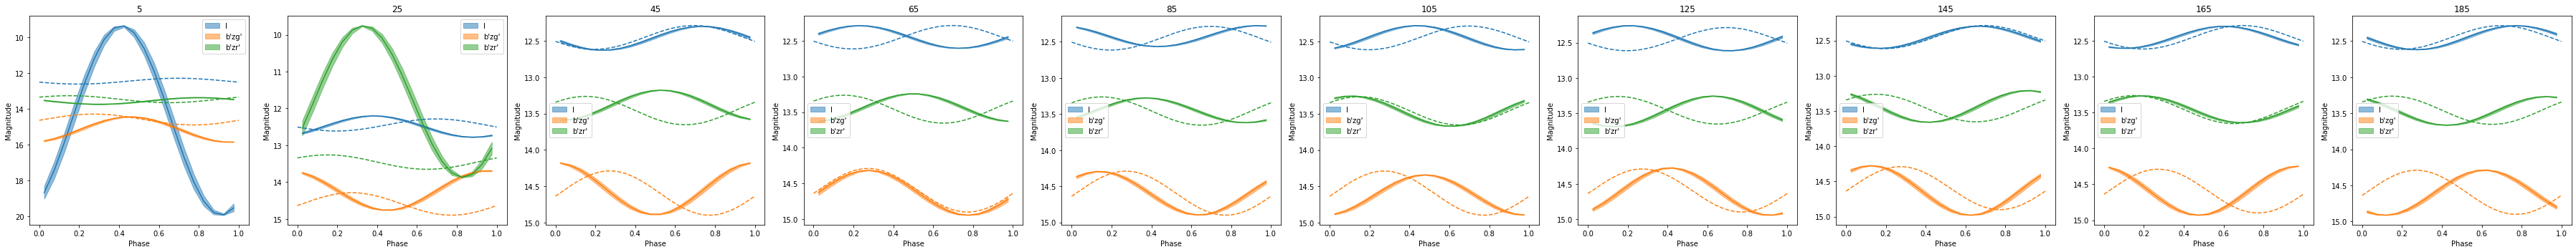

In [43]:
bins = pd.unique(lightcurve_p.index.get_level_values(1))[::4]
fig,ax = plt.subplots(1,bins.size,figsize=(5*bins.size,5))
ax = np.reshape(ax,-1)
for TYPE in pd.unique(pd.unique(lightcurve_p.index.get_level_values(0))):
    for i,N in enumerate(bins):
        for f in pd.unique(lightcurve_p.index.get_level_values(2)):
            m = lightcurve_p.loc[(TYPE,N,f)]
            _=ax[i].plot(m.index,m['p_50'])[0].get_color()
            cut = Kbf[4]==f
            
            ax[i].plot(Kbf[6][cut][0],Kbf[5][cut][0],color=_,ls='dashed')
            ax[i].fill_between(m.index,m['p_16'],m['p_84'],alpha=0.5,color=_,label=f)
        ax[i].legend()
        ax[i].set_xlabel('Phase')
        ax[i].set_ylabel('Magnitude')
        ax[i].set_title(N)
        ax[i].invert_yaxis()
fig.tight_layout()

Text(0, 0.5, 'Period [d]')

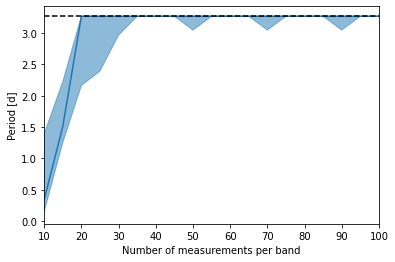

In [45]:
mean = simulated_periods.groupby(simulated_periods['N'],).median()
p16 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),16))
p84 =  simulated_periods.groupby(simulated_periods['N'],).agg(lambda x:np.percentile(x.dropna(),84))
plt.plot(mean.index,mean.P)
plt.fill_between(mean.index,p16.P,p84.P,alpha=0.5,color='C0')
plt.xlim(10,100)
plt.axhline(P0,color='k',ls='dashed')
plt.xlabel('Number of measurements per band')
plt.ylabel('Period [d]')